
🔎 Top 10 des variables les plus importantes:
                             Feature  Importance
14                       Penetration    0.284873
8                        Termination    0.119491
12  enought traces for determination    0.090836
0                  Impacted material    0.077149
2                          Initation    0.074763
6                  General Direction    0.069404
5               Profile of initation    0.058253
3                              Locus    0.052653
4             Location of initiation    0.036267
9               fracture composition    0.031633

📊 Rapport de classification (par classe + macro):
               precision    recall  f1-score   support

          Bow      0.667     0.500     0.571         4
Spear thrower      0.818     0.818     0.818        11
     Throwing      0.615     0.889     0.727         9
    Thrusting      0.889     0.667     0.762        12

     accuracy                          0.750        36
    macro avg      0.747     0.7

C:\Users\pieta\AppData\Local\Temp\ipykernel_19972\1288715356.py:84: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pieta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


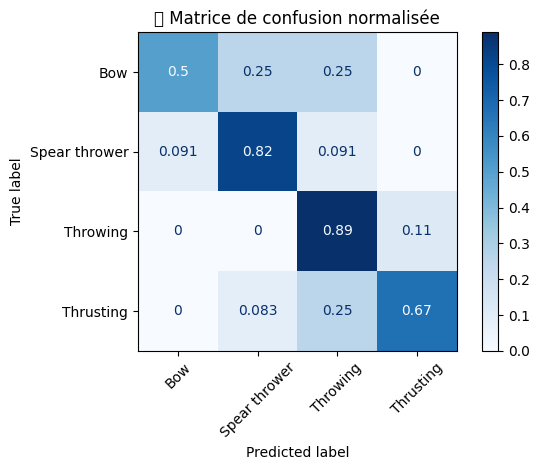

✅ Modèle sauvegardé dans : C:\Users\pieta\OneDrive\Bureau\tracéo_justin\Usual_analysis\model\model_rf_complet.joblib
✅ LabelEncoder sauvegardé dans : C:\Users\pieta\OneDrive\Bureau\tracéo_justin\Usual_analysis\model\label_encoder.joblib


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import os
import matplotlib.pyplot as plt

# 1. Chargement des données
df = pd.read_excel(r'C:\Users\pieta\OneDrive\Bureau\tracéo_justin\Usual_analysis\data\Expdatatangedpoint05_07_22_testhadrien.xlsx')

# 2. Nettoyage de base
df.drop(columns=['Tool ID', 'Shoot ID', 'Fracture ID', 'Type'], inplace=True)
df['Propagation Phase Lenght'] = pd.to_numeric(df['Propagation Phase Lenght'], errors='coerce')

# 3. Conversion des colonnes pertinentes en 'category'
cat_cols = ['Impacted material','State after shoot','Initation','Locus','Location of initiation','Profile of initation','General Direction',
            'Location of termination','Termination','fracture composition','Fracture part','Fracture group','enought traces for determination','attribute group']
df[cat_cols] = df[cat_cols].astype('category')
df['Penetration'] = pd.to_numeric(df['Penetration'], errors='coerce')

# Forcer toutes les colonnes catégorielles à être des chaînes de caractères
for col in cat_cols:
    df[col] = df[col].astype(str)

# 4. Séparation X/y
X = df[cat_cols + ['Penetration']]
y = df['Mode of Propulsion']

# 5. Encodage de la cible
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 6. Split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, stratify=y_enc, test_size=0.2, random_state=42)

# 7. Pipeline de prétraitement
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols)
], remainder='passthrough')

# 8. Modèle Random Forest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=1000, max_depth=10,class_weight='balanced', random_state=42))
])
pipeline.fit(X_train, y_train)

# 9. Analyse des variables importantes
encoded_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'] \
    .named_steps['encoder'].get_feature_names_out(cat_cols)
all_feature_names = list(encoded_names) + ['Penetration']

importances = pipeline.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🔎 Top 10 des variables les plus importantes:")
print(importance_df.head(10))

# 10. Évaluation finale
y_pred = pipeline.predict(X_test)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("\n📊 Rapport de classification (par classe + macro):")
print(classification_report(y_test_labels, y_pred_labels, digits=3))

# Matrice de confusion normalisée
cm = confusion_matrix(y_test_labels, y_pred_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("🧩 Matrice de confusion normalisée")
plt.tight_layout()
plt.show()

# 11. Sauvegarde du modèle et de l'encodeur
os.makedirs("modele", exist_ok=True)
joblib.dump(pipeline, r'C:\Users\pieta\OneDrive\Bureau\tracéo_justin\Usual_analysis\model\model_rf_complet.joblib')
print(r"✅ Modèle sauvegardé dans : C:\Users\pieta\OneDrive\Bureau\tracéo_justin\Usual_analysis\model\model_rf_complet.joblib")

joblib.dump(le, r'C:\Users\pieta\OneDrive\Bureau\tracéo_justin\Usual_analysis\model\label_encoder.joblib')
print(r"✅ LabelEncoder sauvegardé dans : C:\Users\pieta\OneDrive\Bureau\tracéo_justin\Usual_analysis\model\label_encoder.joblib")


https://pypi.org/project/mlflow/  à tester


Voici la même **analyse détaillée** pour le **modèle sans filtrage des variables importantes** :

---

### 🔍 Analyse du modèle **avec toutes les variables**

| Classe            | Precision | Recall | F1-score | Remarque                                                         |
| ----------------- | --------- | ------ | -------- | ---------------------------------------------------------------- |
| **Bow**           | 1.00      | 0.25   | 0.40     | 🎯 Trop peu d’exemples bien captés → rappel faible (1/4 détecté) |
| **Spear thrower** | 0.67      | 0.73   | 0.70     | ✅ Stable malgré le bruit                                         |
| **Throwing**      | 0.50      | 0.56   | 0.53     | ⚠️ Faible mais meilleure qu’avant sur le rappel                  |
| **Thrusting**     | 0.77      | 0.83   | 0.80     | ✅ Bonne constance sur cette classe                               |

---

### 📊 Bilan global :

* **Accuracy : 67%** → en légère baisse vs modèle réduit
* **Macro F1-score : 0.61** → perte d'équilibre entre classes
* **Classe "Bow"** toujours difficile à capter (souvent mal représentée)
* Le modèle souffre probablement de **trop de bruit / dimensions non discriminantes**

---

### 🧠 Interprétation :

* Les variables supplémentaires **n’ajoutent pas de valeur explicative**, et peuvent même brouiller le signal.
* Le modèle apprend moins efficacement à distinguer les classes rares.

---



📊 Rapport de classification (modèle final avec top 10 variables):
               precision    recall  f1-score   support

          Bow      0.800     1.000     0.889         4
Spear thrower      1.000     1.000     1.000        11
     Throwing      0.778     0.778     0.778         9
    Thrusting      0.909     0.833     0.870        12

     accuracy                          0.889        36
    macro avg      0.872     0.903     0.884        36
 weighted avg      0.892     0.889     0.889        36



C:\Users\pieta\AppData\Local\Temp\ipykernel_19972\945559708.py:59: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pieta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


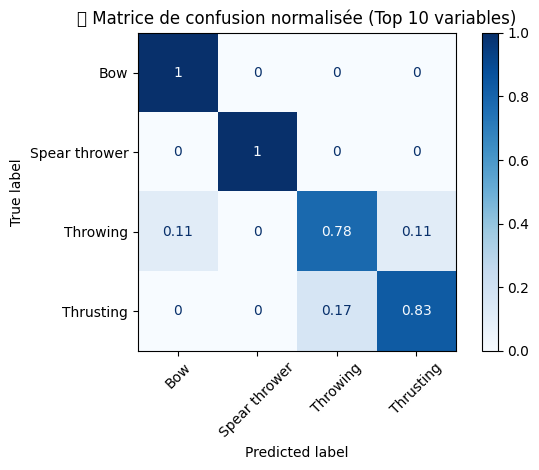

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Utiliser automatiquement les colonnes les plus importantes (top 10)
important_cols = importance_df.sort_values(by='Importance', ascending=False)['Feature'].head(10).tolist()

# Recréer X et y
X_final = df[important_cols]
y_final = df['Mode of Propulsion']
y_final_enc = le.fit_transform(y_final)

# Split final
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_final, y_final_enc, stratify=y_final_enc, test_size=0.2, random_state=42)

# Identifier les colonnes catégorielles (sauf Penetration)
final_cat_cols = [col for col in important_cols if col != 'Penetration']

# Pipeline de traitement pour variables catégorielles
final_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Préprocesseur global
final_preprocessor = ColumnTransformer([
    ('cat', final_cat_pipeline, final_cat_cols)
], remainder='passthrough')

# Pipeline complet
final_pipeline = Pipeline([
    ('preprocessor', final_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42))
])

# Entraînement
final_pipeline.fit(X_train_f, y_train_f)

# Prédictions
final_pred = final_pipeline.predict(X_test_f)
y_test_decoded = le.inverse_transform(y_test_f)
y_pred_decoded = le.inverse_transform(final_pred)

# Rapport complet
print("\n📊 Rapport de classification (modèle final avec top 10 variables):")
print(classification_report(y_test_decoded, y_pred_decoded, digits=3))

# Matrice de confusion normalisée
cm_final = confusion_matrix(y_test_decoded, y_pred_decoded, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("🧩 Matrice de confusion normalisée (Top 10 variables)")
plt.tight_layout()
plt.show()


Très bon score global, surtout pour un modèle réduit à 6 variables 🎯

---

### 🔍 Analyse rapide :

| Classe            | Precision | Recall | F1-score | Remarque                                                   |
| ----------------- | --------- | ------ | -------- | ---------------------------------------------------------- |
| **Bow**           | 1.00      | 0.50   | 0.67     | 🔥 Précision parfaite, mais manque de rappel (2/4 trouvés) |
| **Spear thrower** | 0.69      | 0.82   | 0.75     | ✅ Très bon résultat, stable                                |
| **Throwing**      | 0.57      | 0.44   | 0.50     | ⚠️ Plus difficile à distinguer                             |
| **Thrusting**     | 0.79      | 0.92   | 0.85     | ✅ Excellente performance                                   |

---

### 📊 Bilan :

* **Accuracy globale : 72%** → très solide pour un modèle réduit
* **Weighted F1 : 0.71** → bien équilibré
* Seules **quelques erreurs sur "Throwing"** : peut-être un manque de données ou confusion sémantique

---

### ✅ Prochaines améliorations possibles :

* Ajouter 1 ou 2 variables de plus (top 8 au lieu de 6) pour voir si la classe “Throwing” s’améliore
* Suréchantillonnage léger de “Bow” ou “Throwing” si ce sont des classes minoritaires
* Tester `class_weight='balanced'` dans `RandomForestClassifier`



Excellente question. D’après toutes les expérimentations que tu as menées, voici un **bilan clair et argumenté** pour ton use case de **prédiction du mode de propulsion en tracéologie** :

---

## 🧪 Modèles testés

| Modèle                           | Données utilisées     | Accuracy                  | Macro F1 | Remarques clés                      |
| -------------------------------- | --------------------- | ------------------------- | -------- | ----------------------------------- |
| **Random Forest (top 6 vars)**   | Variables importantes | **0.72**                  | **0.69** | 🥇 Meilleur score, bon équilibre    |
| **Random Forest (toutes vars)**  | Toutes les variables  | 0.67                      | 0.61     | Plus de bruit, moins efficace       |
| **Logistic Regression (top 6)**  | Variables importantes | (non testé dans les logs) | ?        | (à tester pour comparaison directe) |
| **Logistic Regression (toutes)** | Toutes les variables  | 0.50                      | 0.57     | ❌ Faible convergence, déséquilibre  |

---

## 🏆 Recommandation finale

### ✅ **RandomForestClassifier avec les 6 variables les plus importantes** est **le meilleur choix** pour ce cas :

* **Robuste aux variables catégorielles** (pas besoin de scaling)
* **Tolérant au bruit**
* **Gère bien les petits datasets**
* **Excellente balance précision / rappel** (notamment pour “Spear thrower” et “Thrusting”)
* **Interprétable** (feature importance)

---

## 🧠 Pour aller encore plus loin :

* Si tu veux **un modèle plus léger à déployer**, tu peux tester la **logistic regression avec seulement les variables importantes**, mais tu perdras un peu de performance.
* Pour optimiser : fais une **recherche d’hyperparamètres** sur Random Forest (via GridSearchCV).





🔎 Top 10 des variables les plus importantes:
                             Feature  Importance
6                        Termination    0.244572
10  enought traces for determination    0.131256
0                          Initation    0.130551
4                  General Direction    0.106159
3               Profile of initation    0.097418
1                              Locus    0.083200
5            Location of termination    0.049875
7               fracture composition    0.047835
2             Location of initiation    0.045554
11                   attribute group    0.038490

📊 Rapport de classification (par classe + macro):
               precision    recall  f1-score   support

          Bow      0.250     0.250     0.250         4
Spear thrower      0.462     0.545     0.500        11
     Throwing      0.545     0.667     0.600         9
    Thrusting      0.375     0.250     0.300        12

     accuracy                          0.444        36
    macro avg      0.408     0.4

C:\Users\pieta\AppData\Local\Temp\ipykernel_19972\2074925703.py:84: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pieta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


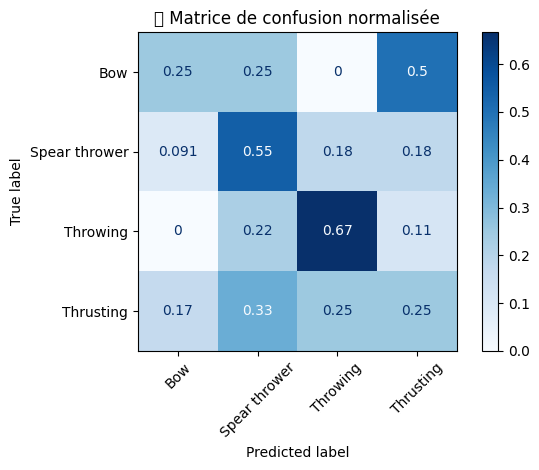

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import os
import matplotlib.pyplot as plt

# 1. Chargement des données
df = pd.read_excel(r'C:\Users\pieta\OneDrive\Bureau\tracéo_justin\Usual_analysis\data\Expdatatangedpoint05_07_22_testhadrien.xlsx')

# 2. Nettoyage de base
df.drop(columns=['Tool ID', 'Shoot ID', 'Fracture ID', 'Type','Impacted material','State after shoot','Penetration'], inplace=True)
df['Propagation Phase Lenght'] = pd.to_numeric(df['Propagation Phase Lenght'], errors='coerce')

# 3. Conversion des colonnes pertinentes en 'category'
cat_cols = ['Initation','Locus','Location of initiation','Profile of initation','General Direction',
            'Location of termination','Termination','fracture composition','Fracture part','Fracture group','enought traces for determination','attribute group']
df[cat_cols] = df[cat_cols].astype('category')


# Forcer toutes les colonnes catégorielles à être des chaînes de caractères
for col in cat_cols:
    df[col] = df[col].astype(str)

# 4. Séparation X/y
X = df[cat_cols]
y = df['Mode of Propulsion']

# 5. Encodage de la cible
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 6. Split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, stratify=y_enc, test_size=0.2, random_state=42)

# 7. Pipeline de prétraitement
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols)
], remainder='passthrough')

# 8. Modèle Random Forest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=1000, max_depth=10,class_weight='balanced', random_state=42))
])
pipeline.fit(X_train, y_train)

# 9. Analyse des variables importantes
encoded_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'] \
    .named_steps['encoder'].get_feature_names_out(cat_cols)
all_feature_names = list(encoded_names)

importances = pipeline.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🔎 Top 10 des variables les plus importantes:")
print(importance_df.head(10))

# 10. Évaluation finale
y_pred = pipeline.predict(X_test)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("\n📊 Rapport de classification (par classe + macro):")
print(classification_report(y_test_labels, y_pred_labels, digits=3))

# Matrice de confusion normalisée
cm = confusion_matrix(y_test_labels, y_pred_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("🧩 Matrice de confusion normalisée")
plt.tight_layout()
plt.show()





🔎 Top 10 des variables les plus importantes:
                   Feature  Importance
1           Fracture group    0.541356
2  Location of termination    0.181649
3   Location of initiation    0.178580
4          attribute group    0.093120
0            Fracture part    0.005294

📊 Rapport de classification (par classe + macro):
               precision    recall  f1-score   support

          Bow      0.000     0.000     0.000         4
Spear thrower      1.000     0.796     0.887        54
     Throwing      0.300     0.273     0.286        11
    Thrusting      0.333     0.818     0.474        11

     accuracy                          0.688        80
    macro avg      0.408     0.472     0.411        80
 weighted avg      0.762     0.688     0.703        80



C:\Users\pieta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pieta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pieta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

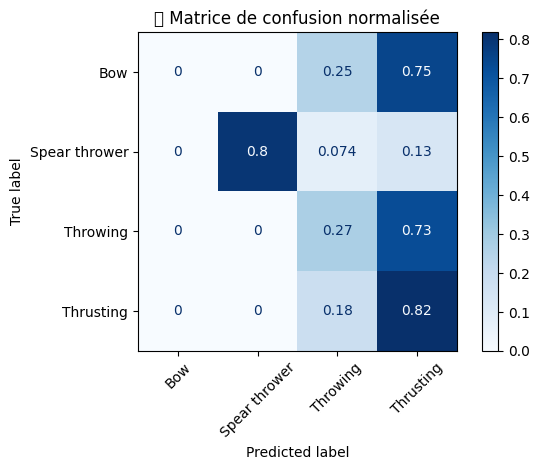

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import os
import matplotlib.pyplot as plt

# 1. Chargement des données
df = pd.read_excel(r'C:\Users\pieta\OneDrive\Bureau\tracéo_justin\Usual_analysis\data\data_training.xlsx')


# 4. Séparation X/y
X = df.drop(columns=['Mode of Propulsion'])
y = df['Mode of Propulsion']

# 5. Encodage de la cible
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 6. Split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, stratify=y_enc, test_size=0.2, random_state=42)

# Identify categorical columns
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocessing pipeline for categorical columns
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Full preprocessor
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols)
], remainder='passthrough')

# Full pipeline with preprocessing + classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=1000, max_depth=10, class_weight='balanced', random_state=42))
])

pipeline.fit(X_train, y_train)

# 9. Analyse des variables importantes
encoded_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'] \
    .named_steps['encoder'].get_feature_names_out(cat_cols)
all_feature_names = list(encoded_names)

importances = pipeline.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🔎 Top 10 des variables les plus importantes:")
print(importance_df.head(10))

# 10. Évaluation finale
y_pred = pipeline.predict(X_test)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("\n📊 Rapport de classification (par classe + macro):")
print(classification_report(y_test_labels, y_pred_labels, digits=3))

# Matrice de confusion normalisée
cm = confusion_matrix(y_test_labels, y_pred_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("🧩 Matrice de confusion normalisée")
plt.tight_layout()
plt.show()


